### Test the physical units, single fundamental 1035nm pulse in, static field, gas absent (vacuum, zero pressure):

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pynlo
from scipy import constants

In [3]:
def photonEnergyGrid(pulse):
    """
    Convert the grid corresponding to the complex electric field in frequency
    domain from angular frequency to photon energy in eV.
    
    Photon energy:
    E[J] = hbar * w = h * v
    E[eV] = E[J] / e
    
    Input(s):
    pulse: a pulse instance on which the conversion is performed.
    Output(s):
    W_eV: photon energy grid [eV].
    """
    
    W_eV = constants.h * pulse.F_mks / constants.e
    
    return W_eV

class GasPropertyBuilder:
    
    def __init__(self, fiber_length, fiber_radius, fiber_wavelength, pulse_wavelength, n2_at_one_bar, betas_at_one_bar,  
                 constant_pressure=None, pressure_boundary=None, differential_pumping=False):
        
        assert (constant_pressure is not None) if not differential_pumping else True, \
        "A constant gas pressure is expected for non-differential pumping scheme."
        assert (pressure_boundary is not None) if differential_pumping else True, \
        "A list containing the boundary values of the gas pressure at both input \
        and output surface of the fiber is expected for differential pumping scheme."
        
        self.fiber_len = fiber_length
        self.fiber_rad = fiber_radius
        self.fibWL = fiber_wavelength
        self.pulseWL = pulse_wavelength
        
        if differential_pumping:
            if len(pressure_boundary) != 2:
                print("A list containing the boundary values of the gas pressure at both input \
                and output surface of the fiber is expected for differential pumping scheme.")
            self.pressure_entr = pressure_boundary[0]
            self.pressure_exit = pressure_boundary[1]
        else:
            self.const_pressure = constant_pressure
        
        self.n2_at_one_bar = n2_at_one_bar
        self.betas_at_one_bar = betas_at_one_bar
        self.differential_pumping = differential_pumping
        
    def torrToBar(self, pressure_Torr):
        """
        Unit conversion for gas pressure from torr to bar.
        
        1 torr is defined as exactly 1/760 of a standard atmosphere (1 atm = 101325 Pa), 
        1 pascal is equal to 1e-5 bar.

        Input(s):
        pressure_Torr: gas pressure [Torr]
        Output(s):
        pressure_Bar: gas pressure [Bar]
        """
        
        pressure_Pa = pressure_Torr * (101325/760)
        pressure_Bar = pressure_Pa * 1e-5
        
        return pressure_Bar

    def pressureDistribution(self, z=None):
        """
        Generate gas pressure distribution along the fiber under differential pumping.

        Reference: 
        Suda, Akira, et al.
        “Generation of Sub-10-Fs, 5-mJ-Optical Pulses Using a Hollow Fiber with a Pressure Gradient.”
        Applied Physics Letters, vol. 86, no. 11, 2005, https://doi.org/10.1063/1.1883706.
        
        Input(s):
        z: position grid along the fiber [m].
        fiber_len: length of the fiber [m].
        pressure_entr: gas pressure at the entrance [Torr].
        pressure_exit: gas pressure at the exit [Torr].
        Output(s):
        pressure_dist: gas pressure distribution along the fiber [Bar].
        """
        if self.differential_pumping:
            pressure_entr = self.torrToBar(self.pressure_entr)
            pressure_exit = self.torrToBar(self.pressure_exit)
            pressure_dist = np.sqrt(pressure_entr**2 + (z/self.fiber_len) * (pressure_exit**2 - pressure_entr**2))
        else:
            pressure_dist = self.torrToBar(self.const_pressure)

        return pressure_dist
        
    def dispersionFunction(self, z=None):
        """
        Generate the fiber dispersion that can vary as a function of the length z along the fiber 
        for differential pumping, return a tuple of beta coefficients as a function of z.
        
        Input(s):
        pressure_dist: gas pressure distribution along the fiber [Bar].
        betas_at_one_bar: a list of beta coefficients (i.e. [beta2, beta3, beta4]) specified at 1 bar [ps^n/km].
        Output(s):
        betas: a tuple of beta coefficients as a function of z [ps^n/m].
        """

        if self.differential_pumping:
            pressure_dist = self.pressureDistribution(z)
        else:
            pressure_dist = self.pressureDistribution()
            
        betas = [beta * (1/1e3) * pressure_dist for beta in self.betas_at_one_bar]
        
        return tuple(betas)
    
    def nonlinearIndexN2(self, z=None):
        """
        Calculate the nonlinear refractive index n2, return a constant for non-differential pumping, 
        or a distribution along the fiber for differential pumping.

        Input(s):
        pressure_dist: gas pressure distribution along the fiber under differential pumping [Bar].
        const_pressure: constant gas pressure for non-differential pumping [Bar].
        n2_at_one_bar: nonlinear refractive index of the gas reported at 1 bar [m^2/(W bar)].
        Output(s):
        n2: nonlinear refractive index at the specified pressure [m^2/W].
        """
        
        assert (z is None) if not self.differential_pumping else True, \
        "A position grid is not needed for non-differential pumping."
        assert (z is not None) if self.differential_pumping else True, \
        "A position grid is needed for differential pumping."
        
        if self.differential_pumping:
            pressure_dist = self.pressureDistribution(z)
        else:
            pressure_dist = self.pressureDistribution()
        
        n2 = pressure_dist * self.n2_at_one_bar
        
        return n2
        
    def gammaDistribution(self, z=None):
        """
        Calculate the nonlinear parameter Gamma using Gamma=(n2*w0)/(c*A_eff), return a constant 
        for non-differential pumping, or a distribution along the fiber for differential pumping. 
        Reference: Agrawal, Govind. Nonlinear Fiber Optics. Sixth edition., Academic Press, 2019.
        
        c: speed of light in vacuum [m/s].
        w0: angular frequency [rad/s].
        A_eff: effective core area of the fiber [m^2].

        Input(s):
        n2: nonlinear refractive index at the specified pressure [m^2/W].
        pulseWL: pulse central wavelength [nm].
        fiber_rad: radius of fiber [m].
        Output(s):
        Gamma: nonlinear parameter [1/(W m)]
        """
        
        assert (z is None) if not self.differential_pumping else True, \
        "A position grid is not needed for non-differential pumping."
        assert (z is not None) if self.differential_pumping else True, \
        "A position grid is needed for differential pumping."
        
        w0 = (2*np.pi*constants.c) / (self.pulseWL*1e-9)
        A_eff = np.pi * self.fiber_rad**2
        
        if self.differential_pumping:
            n2 = self.nonlinearIndexN2(z)
        else:
            n2 = self.nonlinearIndexN2()
            
        Gamma = (n2*w0) / (constants.c*A_eff)
        
        return Gamma


In [4]:
# pulse parameters
FWHM = 0.16         # pulse duration [ps]
pulseWL = 1035      # pulse central wavelength [nm]
EPP = 2e-6          # Energy per pulse [J]
GDD = 0.0           # Group delay dispersion [ps^2]
TOD = 0.0           # Third order dispersion [ps^3]

# fibre parameters
Length = 100        # fiber length [mm]
Alpha = 0.0         # attentuation coefficient [dB/cm]
fiber_rad = 15e-6   # radius [m]
fibWL = pulseWL     # center wavelength of fiber [nm]
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

# dispersive coefficients (betas) and pressure-dependent nonlinear refractive index (n2) for Xenon specified at 800 nm at 1 bar
# reference: Couairon, Arnaud, et al. “From Single-Cycle Self-Compressed Filaments to Isolated Attosecond Pulses in Noble Gases.” 
#            Physical Review. A, Atomic, Molecular, and Optical Physics, vol. 77, no. 5, 2008, https://doi.org/10.1103/PhysRevA.77.053814
beta2 = 0                         # [fs^2/(cm bar)]
beta3 = 0                         # [fs^3/(cm bar)]
beta4 = 0                         # [fs^4/(cm bar)]
n2_Xe_at_one_bar = 0              # [m^2/(W bar)]

beta2 *= (1e-3)**2 / 1e-5         # [ps^2/(km bar)]
beta3 *= (1e-3)**3 / 1e-5         # [ps^3/(km bar)]
beta4 *= (1e-3)**4 / 1e-5         # [ps^4/(km bar)]
betas_at_one_bar = [beta2, beta3, beta4]

# simulation parameters
Window = 5        # simulation window [ps]
Steps = 10        # simulation steps
Points = 2**16    # simulation points
Raman = True      # Enable Raman effect?
Steep = True      # Enable self steepening?

gasbuilder = GasPropertyBuilder(fiber_length=Length*1e-3, fiber_radius=fiber_rad, fiber_wavelength=fibWL, pulse_wavelength=pulseWL, betas_at_one_bar=betas_at_one_bar, constant_pressure=0, 
                                pressure_boundary=None, n2_at_one_bar=n2_Xe_at_one_bar, differential_pumping=False)

# create the fiber
fiber = pynlo.media.fibers.fiber.FiberInstance()
fiber.generate_fiber(Length * 1e-3, center_wl_nm=fibWL, betas=gasbuilder.dispersionFunction(),
                              gamma_W_m=gasbuilder.gammaDistribution(), gain=-alpha)


In [5]:
# create the fundamental pulse
pulse_FD = pynlo.light.DerivedPulses.SechPulse(
    1, FWHM/1.76, pulseWL, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
pulse_FD = pulse_FD.interpolate_to_new_center_wl(pulseWL/3)
pulse_FD.set_epp(EPP)

# create the second harmonic pulse
pulse_SH = pynlo.light.DerivedPulses.SechPulse(
    1, FWHM/1.76, pulseWL/2, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
pulse_SH = pulse_SH.interpolate_to_new_center_wl(pulseWL/3)
pulse_SH.set_epp(EPP)

pulse = pynlo.light.PulseBase.Pulse()
pulse.set_NPTS(Points)
pulse.set_time_window_ps(Window)
pulse.set_center_wavelength_nm(fibWL)
pulse.set_AW(pulse_FD.AW + pulse_SH.AW)

# propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.001, USE_SIMPLE_RAMAN=True,
                 disable_Raman=np.logical_not(Raman),
                 disable_self_steepening=np.logical_not(Steep))

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse_FD, fiber=fiber, n_steps=Steps, reload_fiber_each_step=False)


In [6]:
print(pulse_FD.F_THz.shape, pulse_FD.F_THz, pulse_FD.F_THz.max(), pulse_FD.F_THz.min())
print(pulse_SH.F_THz.shape, pulse_SH.F_THz, pulse_SH.F_THz.max(), pulse_SH.F_THz.min())
print(pulse.F_THz.shape, pulse.F_THz, pulse.F_THz.max(), pulse.F_THz.min())
print(pulse_out.F_THz.shape, pulse_out.F_THz, pulse_out.F_THz.max(), pulse_out.F_THz.min())


(65536,) [-5684.63635362 -5684.43635362 -5684.23635362 ...  7421.96364638
  7422.16364638  7422.36364638] 7422.363646376811 -5684.636353623189
(65536,) [-5684.63635362 -5684.43635362 -5684.23635362 ...  7421.96364638
  7422.16364638  7422.36364638] 7422.363646376811 -5684.636353623189
(65536,) [-6263.94545121 -6263.74545121 -6263.54545121 ...  6842.65454879
  6842.85454879  6843.05454879] 6843.054548792271 -6263.945451207729
(65536,) [-5684.63635362 -5684.43635362 -5684.23635362 ...  7421.96364638
  7422.16364638  7422.36364638] 7422.363646376811 -5684.636353623189


In [7]:
print(pulse_FD.dF_mks, pulse_SH.dF_mks, pulse.dF_mks, pulse_out.dF_mks)

200000000000.01318 200000000000.01318 200000000000.64978 200000000000.01318


In [8]:
def calc_FWHM(pulse):

    time_grid = pulse.T_ps
    intensity_temporal = np.abs(pulse.AT)**2
    intensity_temporal_normalised = intensity_temporal / np.max(intensity_temporal)
    FWHM_filter = np.where(intensity_temporal_normalised > 0.5)[0]
    if len(FWHM_filter) >= 2:
        FWHM = time_grid[FWHM_filter[-1]] - time_grid[FWHM_filter[0]]
        return FWHM
    else:
        print("Pulse does not have a well-defined FWHM.")

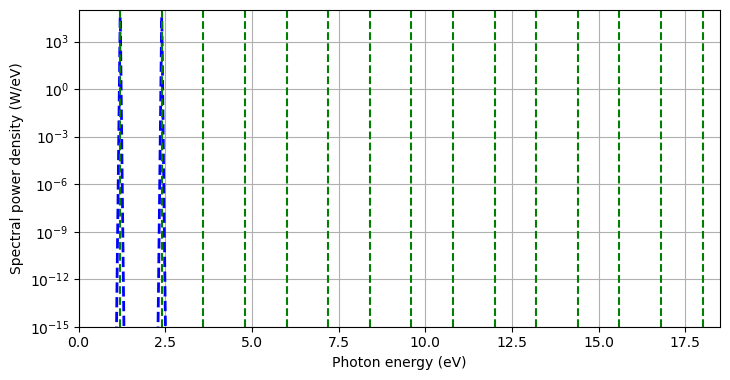

In [11]:
F = (pulse_FD.W_mks / (2*np.pi)) * 1e-12 # convert to THz
E_eV = photonEnergyGrid(pulse_FD)

intensity_FD = np.abs(pulse.AW[(E_eV>0)])**2

plt.figure(figsize=(370/50, 195/50))
plt.plot(E_eV[E_eV > 0], intensity_FD, color='blue', linestyle='dashed', linewidth=2)

plt.xlabel('Photon energy (eV)')
plt.ylabel('Spectral power density (W/eV)')
plt.xlim(0,18.5)
plt.ylim(1e-15,1e5)
plt.yscale('log')

HHGs = [1.2 * (i+1) for i in range(15)]
for HHG in HHGs:
    plt.axvline(x=HHG, color='g', linestyle='--')

plt.grid()
plt.tight_layout()
plt.show()

When gas absent and only fundamental pulse input into fiber, the following quantities are almost conserved:

In [12]:
print(np.abs(pulse_FD.AT[(E_eV>0)])**2, np.trapz(np.abs(pulse_FD.AT[(E_eV>0)])**2))

[2.87508361e+04 2.87996464e+04 2.88485393e+04 ... 4.86727341e-19
 4.86070818e-19 4.85907928e-19] 26197490004.308537


In [13]:
print(np.abs(pulse_out.AT[(E_eV>0)])**2, np.trapz(np.abs(pulse_out.AT[(E_eV>0)])**2))

[2.87508361e+04 2.87996464e+04 2.88485393e+04 ... 5.90033308e-19
 6.12561688e-19 5.44504628e-19] 26197490004.309658


In [14]:
print(np.abs(pulse_FD.AW[(E_eV>0)])**2, np.trapz(np.abs(pulse_FD.AW[(E_eV>0)])**2))

[6.49299010e-32 7.89762765e-30 2.40822339e-30 ... 3.13073806e-31
 6.25860372e-31 3.03005288e-31] 400000.00000000006


In [15]:
print(np.abs(pulse_out.AW[(E_eV>0)])**2, np.trapz(np.abs(pulse_out.AW[(E_eV>0)])**2))

[1.55324404e-28 3.13494251e-28 2.04045235e-27 ... 1.30840652e-27
 3.53020397e-27 2.82124561e-27] 400000.0000000172


The pulse energy is calculated by:

In [16]:
print(pulse_FD.calc_epp(), pulse_FD.dT_mks * np.trapz(np.abs(pulse_FD.AT)**2))

1.9999999999999995e-06 1.9999999999999995e-06


In [17]:
print(pulse_out.calc_epp(), pulse_out.dT_mks * np.trapz(np.abs(pulse_out.AT)**2))

2.000000000000086e-06 2.000000000000086e-06


Thus, `np.trapz(np.abs(pulse_out.AT)**2)` and `np.abs(pulse_out.AT)**2` are in [W]

In [18]:
print(np.trapz(np.abs(pulse_FD.AT)**2), np.abs(pulse_FD.AT)**2)

26214399999.999996 [4.84403222e-19 4.85929684e-19 4.86136631e-19 ... 4.86727341e-19
 4.86070818e-19 4.85907928e-19]


In [19]:
print(np.trapz(np.abs(pulse_out.AT)**2), np.abs(pulse_out.AT)**2)

26214400000.001125 [4.79352457e-19 4.97520394e-19 5.25617031e-19 ... 5.90033308e-19
 6.12561688e-19 5.44504628e-19]


Average power is in [W] and is $P_{avg} = \frac{E}{\Delta t} = E \times f_{rep}$:

In [20]:
P_avg_FD = pulse_FD.calc_epp() * pulse_FD.frep_mks
P_avg_out = pulse_out.calc_epp() * pulse_out.frep_mks
print(P_avg_FD, P_avg_out)


1.9999999999999996 2.0000000000000857


Input fundamental pulse has EPP of 2e-6J and repetition rate of 1MHz, resulting in average power of 2W too, confirming above.

`Window` is 5ps, `Points` is 2^16, `dT_ps` is `Window`/`Points`

In [21]:
print(Window/Points, pulse_FD.dT_ps)

7.62939453125e-05 7.62939453125e-05


`dF_THz` is 1/`Window`

In [22]:
print(1/Window, pulse_FD.dF_THz)

0.2 0.20000000000013685


The pulse energy is also calculated by:

In [24]:
print(np.trapz(np.abs(pulse_FD.AW)**2) / pulse_FD.dF_mks)

1.9999999999998678e-06


In [32]:
print(np.trapz(np.abs(pulse_out.AW)**2) / pulse_out.dF_mks)

1.9999999999999597e-06


Thus, np.trapz(np.abs(pulse_out.AW)**2) and np.abs(pulse_out.AW)**2 are also in [W]

In [33]:
print(np.trapz(np.abs(pulse_FD.AW)**2), np.abs(pulse_FD.AW)**2)

399999.99999999994 [1.81572377e-32 1.52584568e-31 3.40661038e-31 ... 3.13073806e-31
 6.25860372e-31 3.03005288e-31]


In [34]:
print(np.trapz(np.abs(pulse_out.AW)**2), np.abs(pulse_out.AW)**2)

400000.00000001834 [9.93123118e-29 8.66230082e-28 1.62500105e-27 ... 7.94632323e-28
 1.83476823e-27 2.49710606e-27]


Peak pulse power is in [W] and is $P_{peak} = \frac{E}{\tau}$:

In [36]:
P_peak_FD = pulse_FD.calc_epp() / (calc_FWHM(pulse_FD)*1e-12)
P_peak_out = pulse_out.calc_epp() / (calc_FWHM(pulse_out)*1e-12)
print(P_peak_FD, P_peak_out)


12506870.22900763 12506870.229008205


Input fundamental pulse has EPP of 2e-6J and FWHM of 0.16ps, resulting in peak power of 1.25e7W too, confirming above.